<a href="https://colab.research.google.com/github/ArturoSirvent/TFG_notebooks/blob/main/single_input/segundo_intento_prediccion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Todo esta liado, voy a ordenarlo aqui, porque vaya puta mierda.
La estructura será:
* Funciones importantes
* Intento sin autoencoder
* Intento con autoencoder
* Intentos variados con normalization batch

# Librerias

In [ ]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow.keras.backend as K

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Funciones importantes

In [ ]:
import sys

vars().keys()
for i in vars().keys():
    print(i,sys.getsizeof(vars()[i]))

In [ ]:
#nos falta cargar lo datos.
#esto puede ser un poco triky porque necesitamos cargar para los mismos 4 telescopios, 
#de diferentes carpetas y varias RUNS (si no todas)
def load_data(npy_dir,tels=None,runs=None,indices_runs=None,only_names=True,ending=".npy",return_with_labels=False,test_size=0.2):
    #aplicamos regular expresions para extraer los documentos deseados
    #usamos glob
    #si no pasamos ni los tesls ni las runs, deolvemos todos los arichivos
    #es poco optimo este uso de glob, pero es mas flexivo porque le puedo pasar los tels concretos y los runs concretos
    #si es return sin labels, nos devuelve todo, sin separar siquiera

    lista=[]
    if ((type(tels)==list) or (type(tels)==np.ndarray))and (len(tels)!=1):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            for j in runs:
                regex=f"{npy_dir}/*_tel_{i}_run_{str(j).zfill(2)}_?{ending}"
                aux=glob.glob(regex)
                if aux:
                    lista.extend(aux)
                else:
                    #si no lo encuentra entonces nos saldra mal la cosa
                    print("ERROR")
                    print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")

    elif (type(runs)==list) or (type(runs)==np.ndarray):
        #si no es una lista pero las runs si entonces seguimos con esto
        for j in runs:
            regex=f"{npy_dir}/*_tel_{tels}_run_{str(j).zfill(2)}_?{ending}"
            aux=glob.glob(regex)
            if aux:
                lista.extend(aux)
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")
    elif (tels==None) and (runs==None):
        #y sino por ultimo esto
        regex=f"{npy_dir}/*_tel_*_run_*_?{ending}"
        aux=glob.glob(regex)
        if aux:
            lista.extend(aux)
    else:
        print("ERROR")
    if only_names:
        return lista
    else:
        if indices_runs!=None:
            if return_with_labels:
                lista_npy=np.load(lista[0])[indices_runs[0]]
                for m,k in enumerate(lista[1:]):
                    lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
                x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
                return x_train,x_test,y_train,y_test
            else:
                lista_npy=np.load(lista[0])[indices_runs[0]]
                for m,k in enumerate(lista[1:]):
                    lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
                return lista_npy
        else:
            if return_with_labels:
                lista_npy=np.load(lista[0])
                for m,k in enumerate(lista[1:]):
                    lista_npy=np.concatenate((lista_npy,np.load(k)),axis=0)
                x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
                return x_train,x_test,y_train,y_test


            else:
                lista_npy=np.load(lista[0])
                for m,k in enumerate(lista[1:]):
                    lista_npy=np.concatenate((lista_npy,np.load(k)),axis=0)
                return lista_npy


In [ ]:
def get_common_events(npy_dir_base,tels=None,run=None):
    #esta funcion nos sirve para obtener los indices de eventos comunes tal que 
    #esto es necesario para que las imagenes sean del mismo evento

    #TENEMOS QUE MIRAR PARA UNA RUN, TODOS LOS TELESCOPIOS QUE NOS INTERESEN,
    #SIN IMPORTAR EL ELEMENTO, SOLO LOS TELESCOPIOS DE LA RUN Y EL EMENTO QUE TOQUE
    lista=[]
    if (type(tels)==list) or (type(tels)==np.ndarray):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            regex=f"{npy_dir_base}/id_eventos_*_tel_{i}_run_{str(run).zfill(2)}.npy"
            aux=glob.glob(regex)
            if aux:
                lista.append(np.load(aux[0]))
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir_base)} no se encuentra el {os.path.basename(regex)}.")
    else:
        print("ERROR")
        return None
    if len(tels)==1:
        eventos_comunes=lista[0]
    else:
        sets=[set(i) for i in lista]
        #devolvemos una lista de los INDICES de los eventos que SON COMUNES y podemos coger
        eventos_comunes=sorted(list(sets[0].intersection(*sets[1:])))
        del sets
    indices_master=[]
    for i,j in enumerate(tels):
        indices=[]
        for k in eventos_comunes:
            indices.append(np.where(lista[i]==k)[0][0])
        indices_master.append(np.array(indices))
    return np.array(indices_master)




In [ ]:
#MODIFICACION PARA QUE HAYA MAS O MENOS LA MISMA CANTIDAD DE DATOS DE CADA UNO.
def load_dataset(base_dir,pre_name_folders="npy_",telescopios=None,list_runs=None,elementos=None,test_size=0.2,normalizacion_mal=False,same_quant=True):#,ponderaciones=None):
    #telescopios deb ser una lista , aunque solo haya uno 1
    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    eventos_elementos=[]
    numero_eventos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir}/{pre_name_folders}{j}"
        eventos_runs=[]
        for l,k in enumerate(list_runs):
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            eventos_runs.append(aux_events)
            numero_eventos.append(aux_events.shape[1])
        eventos_elementos.append(eventos_runs)

    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]
    #prueba=ponderaciones
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir}/{pre_name_folders}{j}"
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            if same_quant:
                #aux_quant=int(np.median(numero_eventos))
                aux_quant=int(sorted(numero_eventos)[-4])
                data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:aux_quant] for m in eventos_elementos[i]],only_names=False)
            else:
                data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)
            print(data_aux.shape)
            if normalizacion_mal:
                maximo_aux=np.amax(data_aux)
            else:
                maximo_aux=1
            if (i==0) :
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.zeros(label_size)
                data=data_aux/maximo_aux
                del data_aux
            else:
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.concatenate((labels,np.ones(label_size)*i),axis=0)
                data=np.concatenate((data,data_aux/maximo_aux),axis=0)
                del data_aux
        #print(data.shape)
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            labels=tf.keras.utils.to_categorical(labels)
            x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
            del data,labels
            y_train_list=y_train
            y_test_list=y_test
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            #del y_train,y_test
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train)
            x_test_list.append(x_test)
        #del x_train,x_test

    if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
        print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
        return None
    else:
        print("EXITO")
        if len(telescopios)==1:
            return x_train_list[0],x_test_list[0],y_train_list,y_test_list
        else:
            return x_train_list,x_test_list,y_train_list,y_test_list



# Intentos sin autoecoder

# Intentos con BN

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"

#creamos el model de zero
#tenemos 4 inputs
telesc=4
input1=tf.keras.Input(shape=(55,93,1))
input2=tf.keras.Input(shape=(55,93,1))
input3=tf.keras.Input(shape=(55,93,1))
input4=tf.keras.Input(shape=(55,93,1))

#autoencoder=tf.keras.models.load_model(f"{npy_base}/autoencoder_bien.h5")
#autoencoder.trainable=False
#entran los 4 inputs y nos dan 4 outputs diferentes

#output1=autoencoder(input1)
#output2=autoencoder(input2)
#output3=autoencoder(input3)
#output4=autoencoder(input4)

#ahora los outputs los procesamos tal que todos se procesan por el mismo submodelo
aux_input=tf.keras.Input(shape=(55,93,1))
x=tf.keras.layers.Conv2D(128,(3,3),padding="same")(aux_input)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)
#x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
#x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),padding="same")(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.ReLU()(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu",kernel_regularizer='l2')(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu",kernel_regularizer='l2')(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu",kernel_regularizer='l2')(x)
x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Flatten()(x)
submodel_conv=tf.keras.Model(inputs=aux_input,outputs=x)

final_output1=submodel_conv(input1)
final_output2=submodel_conv(input2)
final_output3=submodel_conv(input3)
final_output4=submodel_conv(input4)

end_layer=tf.keras.layers.concatenate([final_output1,final_output2,final_output3,final_output4])
end_layer=tf.keras.layers.Dropout(0.3)(end_layer)
end_layer=tf.keras.layers.Dense(70,activation="relu",kernel_regularizer='l2')(end_layer)
end_layer=tf.keras.layers.Dropout(0.2)(end_layer)
end_layer=tf.keras.layers.Dense(7,activation="softmax")(end_layer)
model=tf.keras.Model(inputs=[input1,input2,input3,input4],outputs=end_layer,name="prueba_red")

In [ ]:
def create_model(num_inputs,dims_inputs,num_class,pre_model=None,copy_pre=False):
#una funcion para crear el modelo con diferentes parámetros

    def block(input_lay):
        #x=tf.keras.layers.Lambda(lambda_func)(input_lay)
        x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(input_lay)
        x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Flatten()(x)
        #x=tf.keras.layers.Dropout(0.3)(x)
        #x=tf.keras.layers.Dense(25,activation="relu")(x)
        return x
    #creamos los diferentes inputs para nuestra funcion
    if len(dims_inputs)==1:
        dims_inputs=[dims_inputs[0] for _ in range(num_inputs)]
    inputs=[]
    for i in range(num_inputs):
        inputs.append(tf.keras.Input(shape=dims_inputs[i]))

    if not pre_model:
        #si no se nos pasa un modelo para el input lo que hacemos es crearlo
        #a cada input le vamos a aplicar la misma capa de feature extraction

        output_clasify=[]
        for j in inputs:
            output_clasify.append(block(j))

    elif pre_model:
        #en teoria es una lista de modelos, pero si la lista de solo uno, vamos a tomar ese para todas las ramas
        output_clasify=[]
        if len(pre_model)==1:
            if copy_pre:
                pesos=pre_model[0].get_weights()
                pre_model_new=[tf.keras.models.clone_model(pre_model[0]) for _ in range(num_inputs)]
                for i in range(num_inputs):
                    pre_model_new[i].set_weights(pesos)
                    pre_model_new[i]._name=f"Feature_extraction_{i+1}"
            else:
                pre_model_new=[pre_model[0] for _ in range(num_inputs)]
            for i,j in enumerate(inputs):
                output_clasify.append(pre_model_new[i](j))
        else:
            for i,j in enumerate(inputs):
                output_clasify.append(pre_model[i](j))
    if num_inputs==1:
        end_layer=tf.keras.layers.Dense(55,activation="relu")(output_clasify[0])
    else:
        end_layer=tf.keras.layers.Concatenate()(output_clasify)
        end_layer=tf.keras.layers.Dense(55,activation="relu")(end_layer)
    end_layer=tf.keras.layers.Dropout(0.3)(end_layer)
    end_layer=tf.keras.layers.Dense(28,activation="relu")(end_layer)
    end_layer=tf.keras.layers.Dropout(0.3)(end_layer)
    end_layer=tf.keras.layers.Dense(14,activation="relu")(end_layer)
    end_layer=tf.keras.layers.Dense(num_class,activation="softmax")(end_layer)
    model=tf.keras.Model(inputs=inputs,outputs=end_layer,name="prueba_red")
    return model

Model: "prueba_red"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 55, 93, 1)]  0                                            
_________________________________________________________________________________________

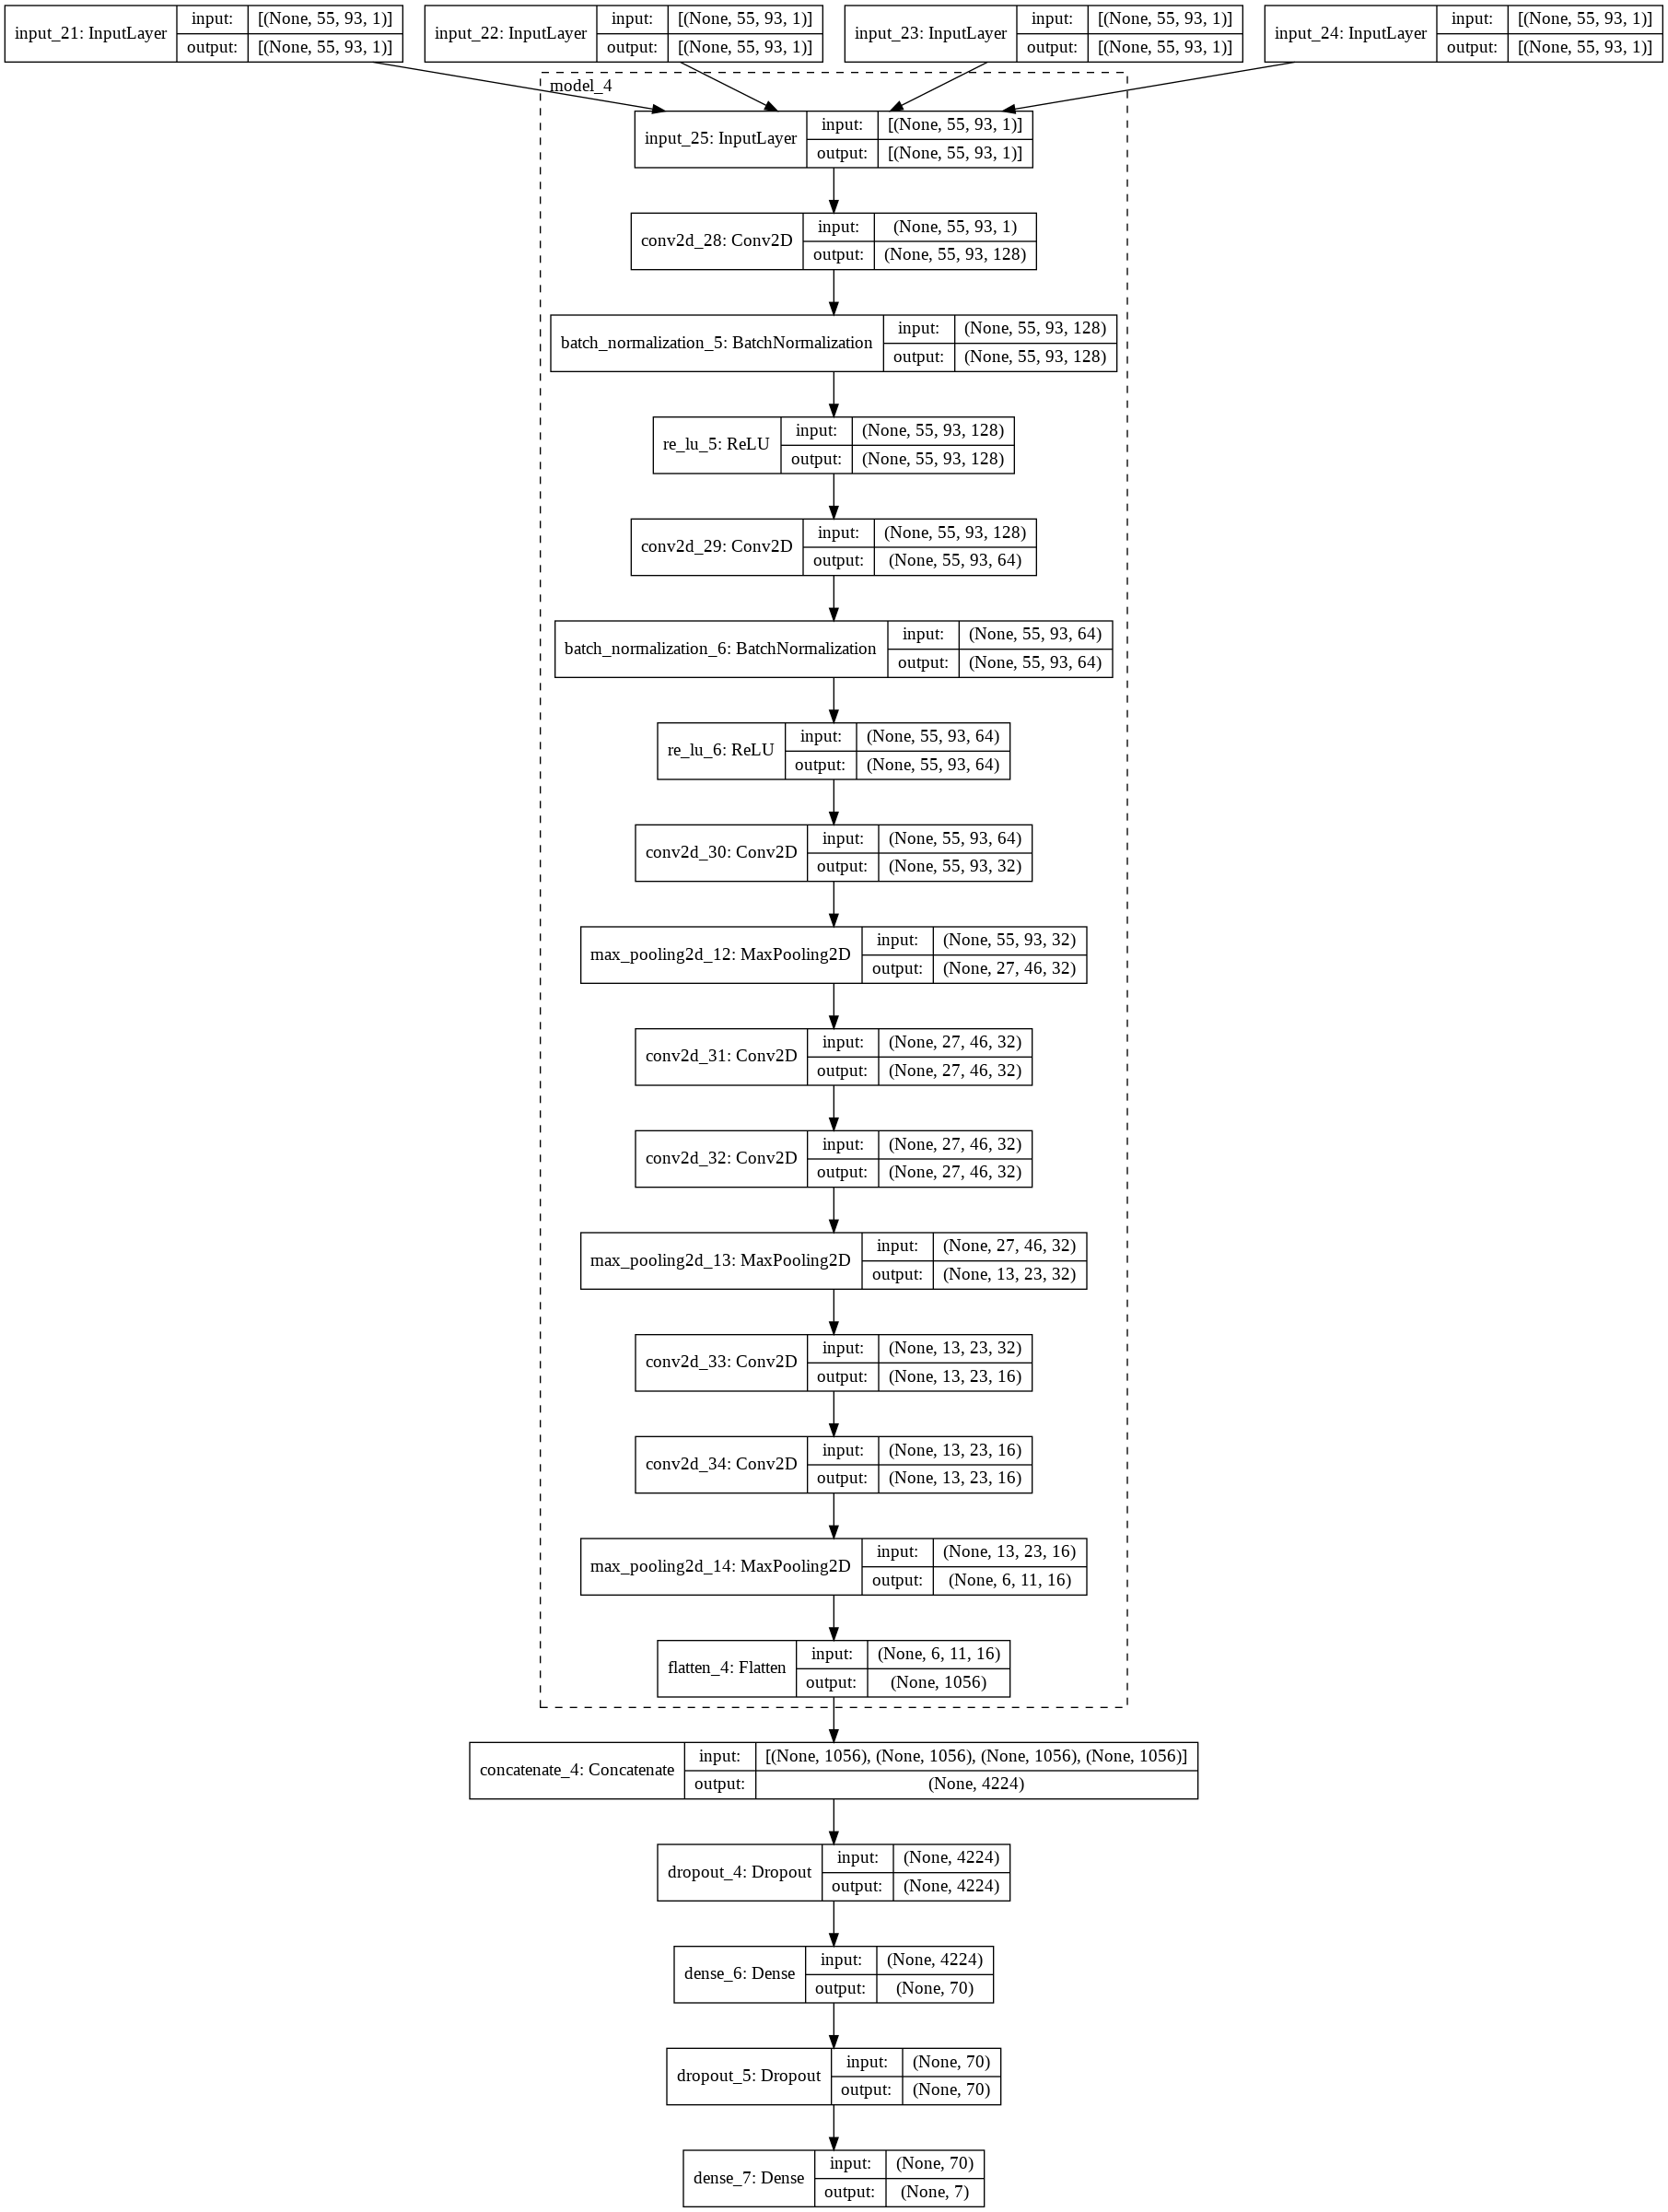

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, "prueba_1.png", show_shapes=True,expand_nested=True)

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

x_train,x_test,y_train,y_test=load_dataset(npy_base,telescopios=[6,11,4,5],list_runs=[8,9],test_size=0.2,normalizacion_mal=False,same_quant=True)

(662, 55, 93)
(209, 55, 93)
(662, 55, 93)
(486, 55, 93)
(247, 55, 93)
(239, 55, 93)
(267, 55, 93)
(662, 55, 93)
(209, 55, 93)
(662, 55, 93)
(486, 55, 93)
(247, 55, 93)
(239, 55, 93)
(267, 55, 93)
(662, 55, 93)
(209, 55, 93)
(662, 55, 93)
(486, 55, 93)
(247, 55, 93)
(239, 55, 93)
(267, 55, 93)
(662, 55, 93)
(209, 55, 93)
(662, 55, 93)
(486, 55, 93)
(247, 55, 93)
(239, 55, 93)
(267, 55, 93)
EXITO


In [ ]:
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6)
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])


In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

for i in range(1,19):
    if (i==3):
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss="categorical_crossentropy",metrics=["accuracy"])
    x_train,x_test,y_train,y_test=load_dataset(npy_base,telescopios=[6,11,4,5],list_runs=[i,i+1,i+2],test_size=0.1,normalizacion_mal=False,same_quant=True)
    hist=model.fit(x_train,y_train,epochs=12,batch_size=32,validation_data=(x_test,y_test),callbacks=[stop])


(4, 1999)
(4, 1999)
(4, 1999)
(4, 115)
(4, 106)
(4, 104)
(4, 327)
(4, 347)
(4, 342)
(4, 225)
(4, 249)
(4, 250)
(4, 130)
(4, 126)
(4, 111)
(4, 106)
(4, 107)
(4, 119)
(4, 136)
(4, 135)
(4, 128)
(1041, 55, 93)
(325, 55, 93)
(1016, 55, 93)
(724, 55, 93)
(367, 55, 93)
(332, 55, 93)
(399, 55, 93)
(1041, 55, 93)
(325, 55, 93)
(1016, 55, 93)
(724, 55, 93)
(367, 55, 93)
(332, 55, 93)
(399, 55, 93)
(1041, 55, 93)
(325, 55, 93)
(1016, 55, 93)
(724, 55, 93)
(367, 55, 93)
(332, 55, 93)
(399, 55, 93)
(1041, 55, 93)
(325, 55, 93)
(1016, 55, 93)
(724, 55, 93)
(367, 55, 93)
(332, 55, 93)
(399, 55, 93)
EXITO
Epoch 1/12
119/119 [==============================] - 18s 149ms/step - loss: 1.2500 - accuracy: 0.5644 - val_loss: 1.2701 - val_accuracy: 0.5748
Epoch 2/12
119/119 [==============================] - 17s 142ms/step - loss: 1.2007 - accuracy: 0.5876 - val_loss: 1.2248 - val_accuracy: 0.5606
Epoch 3/12
119/119 [==============================] - 17s 139ms/step - loss: 1.1900 - accuracy: 0.6011 - val_los

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
#model.save(f"{npy_base}/modelo_bien_tels_6_11_4_5_precision_082.h5")

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

x_train,x_test,y_train,y_test=load_dataset(npy_base,telescopios=[6,11,4,5],list_runs=[10,11,12,15],test_size=0.99,normalizacion_mal=False,same_quant=True)

(7988, 55, 93)
(455, 55, 93)
(1451, 55, 93)
(1007, 55, 93)
(511, 55, 93)
(495, 55, 93)
(517, 55, 93)
(7988, 55, 93)
(455, 55, 93)
(1451, 55, 93)
(1007, 55, 93)
(511, 55, 93)
(495, 55, 93)
(517, 55, 93)
(7988, 55, 93)
(455, 55, 93)
(1451, 55, 93)
(1007, 55, 93)
(511, 55, 93)
(495, 55, 93)
(517, 55, 93)
(7988, 55, 93)
(455, 55, 93)
(1451, 55, 93)
(1007, 55, 93)
(511, 55, 93)
(495, 55, 93)
(517, 55, 93)
EXITO


In [ ]:
#esto es sin same quant
model.evaluate(x_test,y_test)

18/18 [==============================] - 1s 41ms/step - loss: 1.4320 - accuracy: 0.5838


[1.4319554567337036, 0.5837838053703308]

In [ ]:
#esto es con same quant
model.evaluate(x_train,y_train)

94/94 [==============================] - 4s 46ms/step - loss: 1.9897 - accuracy: 0.5477


[1.9897148609161377, 0.5477386713027954]

In [ ]:
    y_predicho=model.predict(x_test)

In [ ]:
matrix=confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_predicho,axis=-1))

In [ ]:
for i in range(7):
    matrix[i,i]=1

In [ ]:
def print_conf_matrix(matrix,elements=None,sin_diag=True):
    if elements is None:
        elements=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if sin_diag:
        for i in range(len(elements)):
            matrix[i,i]=0
    plt.figure(figsize=(13,13))
    sns.heatmap(matrix,annot=True)

    plt.yticks(np.arange(len(elements))+0.25,elements,fontsize=14,rotation=45);
    plt.xticks(np.arange(len(elements))+0.25,elements,fontsize=14,rotation=45);
    plt.title("True label en el eje Y, predicted en el eje X", fontsize=15)

In [ ]:
def comp_and_diplay_conf_matrix(y_test,y_predict):
    matrix=confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_predict,axis=-1))
    print_conf_matrix(matrix)

Text(0.5, 1.0, 'True label en el eje Y, preducted en el eje X')

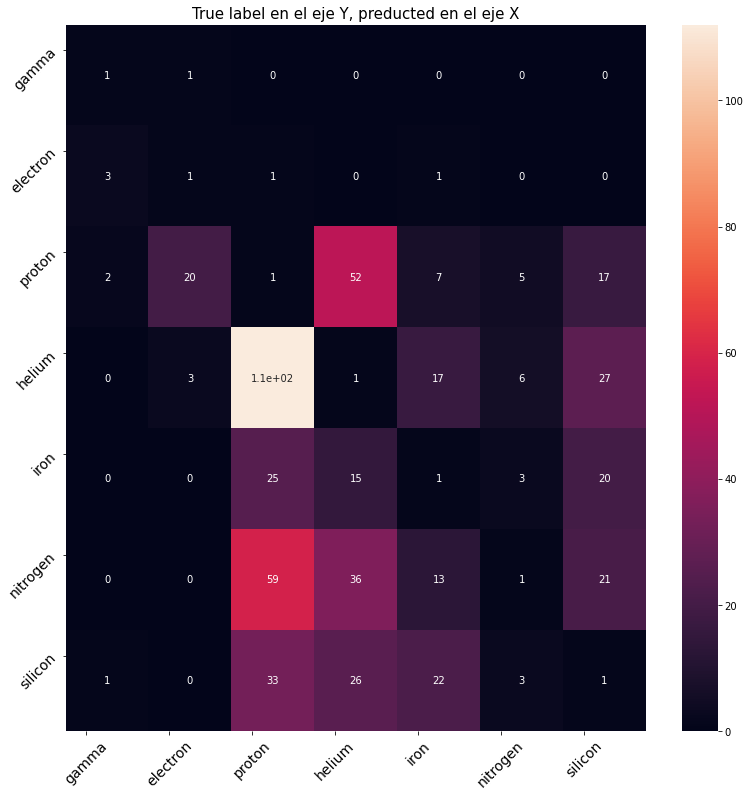

In [ ]:
plt.figure(figsize=(13,13))
sns.heatmap(matrix,annot=True)
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
plt.yticks(np.arange(7)+0.25,elementos,fontsize=14,rotation=45);
plt.xticks(np.arange(7)+0.25,elementos,fontsize=14,rotation=45);
plt.title("True label en el eje Y, predicted en el eje X", fontsize=15)

Confunde mucho muchisimo el helio

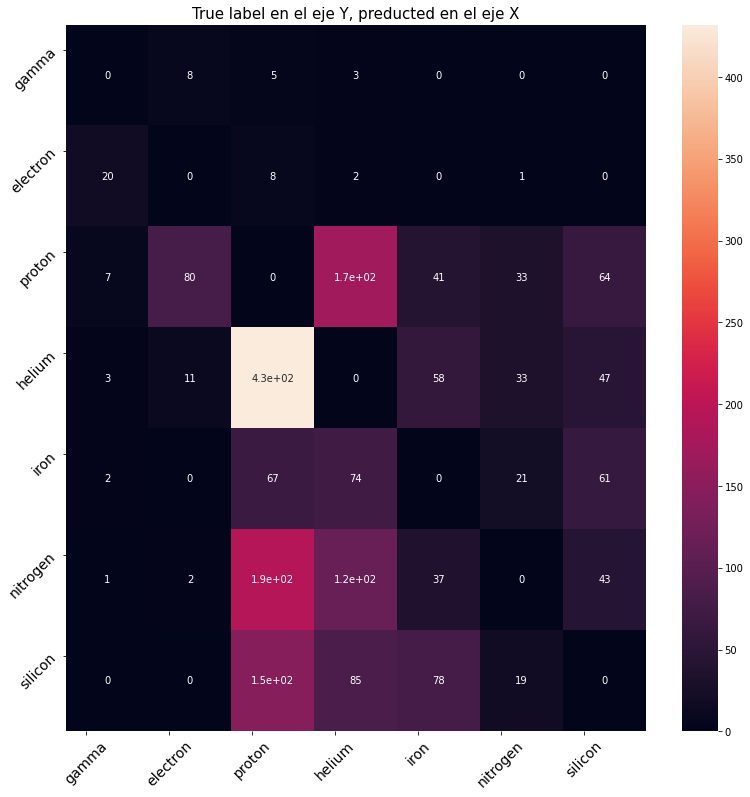

In [ ]:
#ahora con 4 runs 
y_predicho=model.predict(x_test)
matrix=confusion_matrix(np.argmax(y_test,axis=-1),np.argmax(y_predicho,axis=-1))
print_conf_matrix(matrix)

In [ ]:
#vamos a ver porque puede ser eso
def display_max_errores(x_test,y_test,y_predicted,true_index=None,predict_index=None,sort_max=False):
    #primero tenemos que sacar aquellos que tengan maxima discrepancia entre lo predicho y lo real
    indices={}
    a=0
    if (true_index is None) or (predict_index is None):
        print("Dime que elemento quieres ver sus errores")
        return None
    for i,j in enumerate(y_test):
        true_ind=np.argmax(j)
        predict_ind=np.argmax(y_predicted[i])
        if (true_ind!=predict_ind) and ((true_ind==true_index) and (predict_ind==predict_index)):
            indices[i]=y_predicted[i][predict_index], y_predicted[i][true_index]
    return indices
    #devolvemos el indice en el que se encuentra en x_test el error, y el valor con el que se a creido que era cierto (pero no lo es)
    #te devuelvo (como ha creido erroneamente que era, como es realmente)

In [ ]:
a=display_max_errores(x_test,y_test,y_predicho,true_index=3,predict_index=2,sort_max=False)
falsa_creencia=np.array(list(a.values()))[:,0]
real_malpredicho=np.array(list(a.values()))[:,1]
plt.figure(figsize=(13,13))
plt.hist(falsa_creencia,bins=14)
plt.figure(figsize=(13,13))
plt.hist(real_malpredicho,bins=14)

Al representar los histogramas podemos ver si las que se equivoca ahora lo hace porque esta muy cerca del 50% o porque se equivoca muchisimo

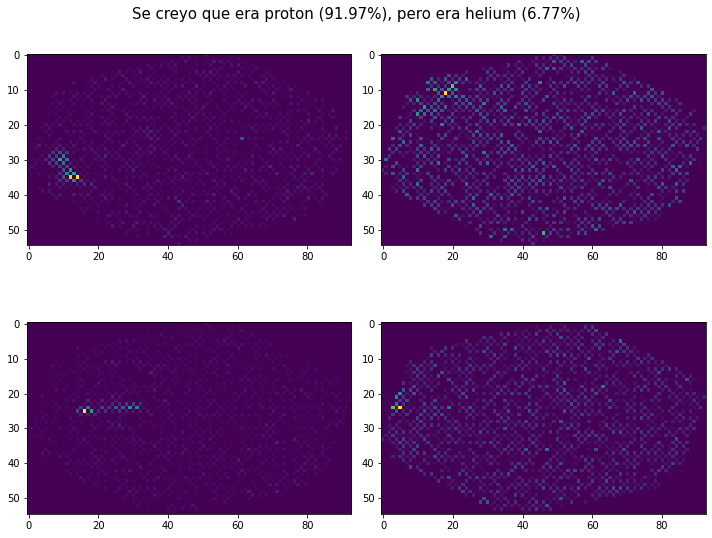

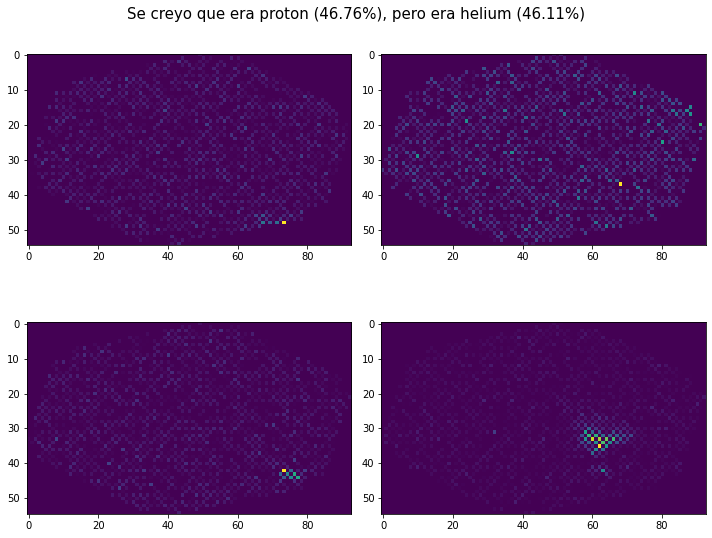

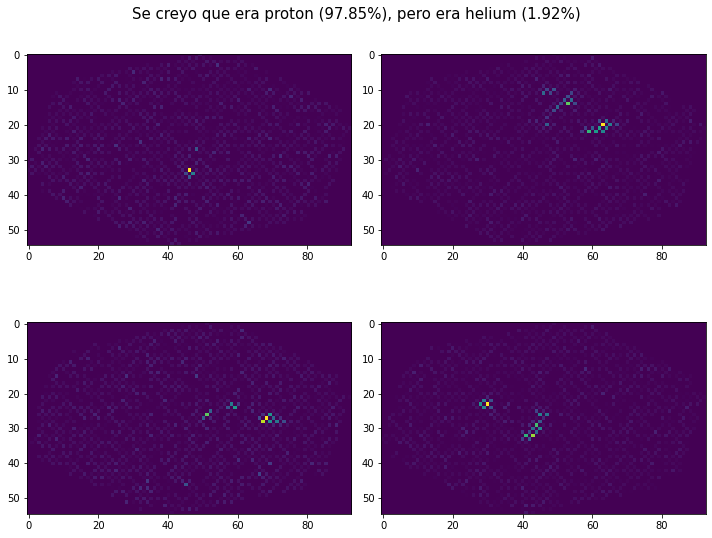

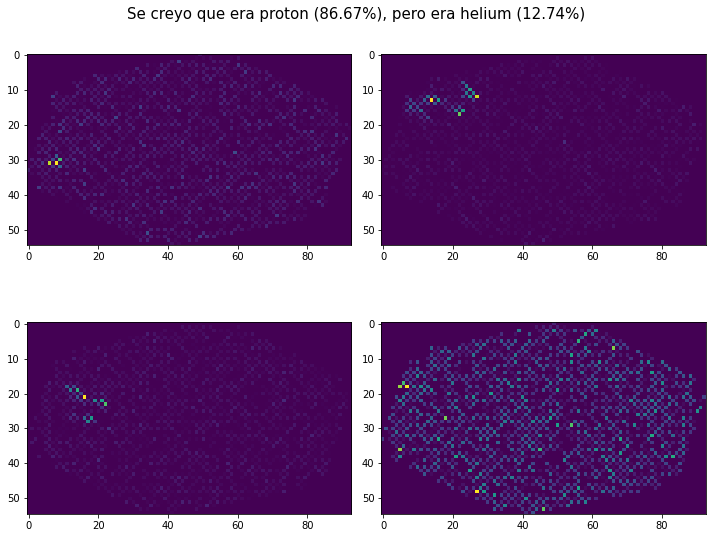

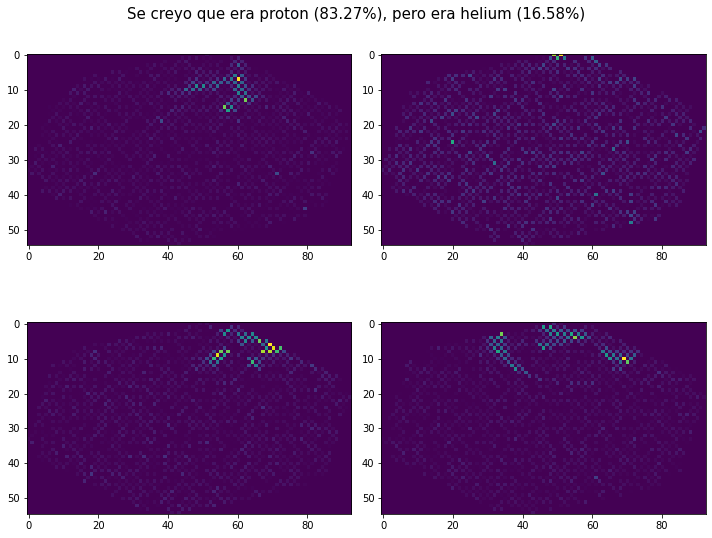

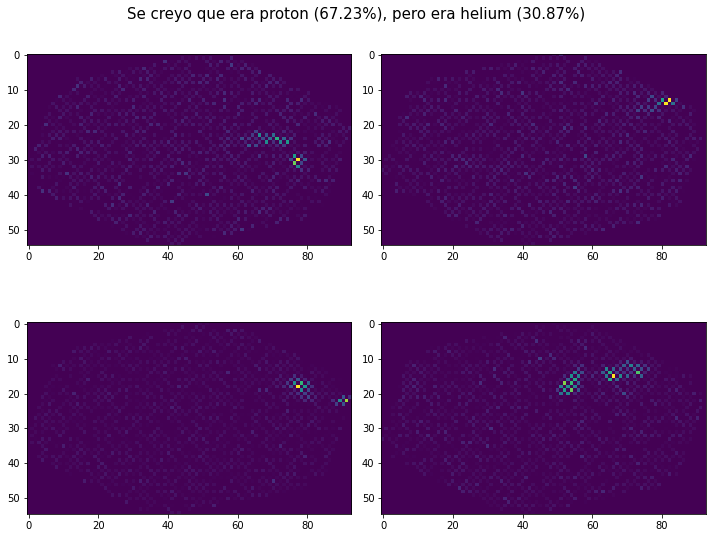

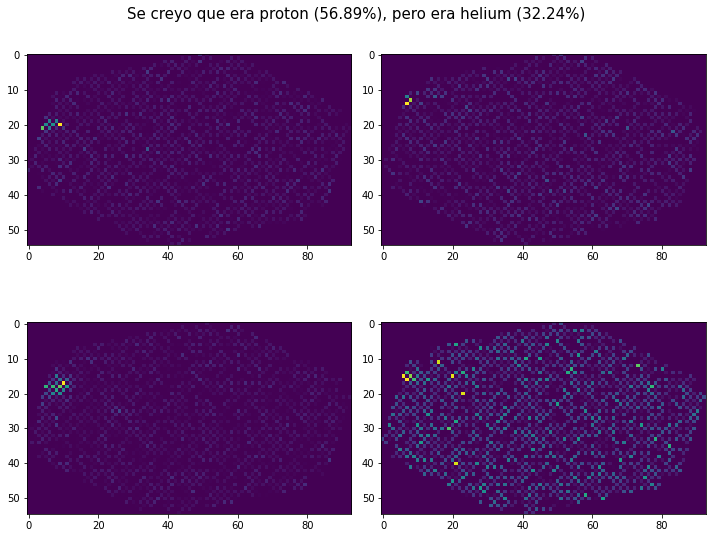

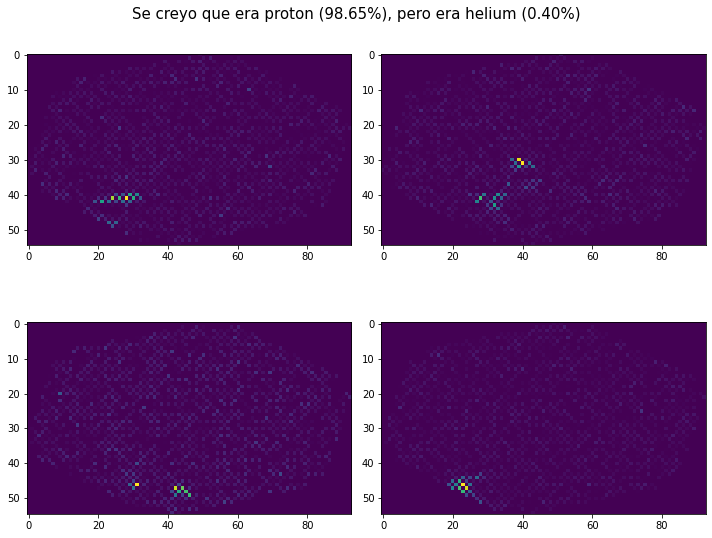

In [ ]:
true_index=3
predict_index=2
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']

a=display_max_errores(x_test,y_test,y_predicho,true_index=true_index,predict_index=predict_index,sort_max=False)
#vamos a ver algunos de los que se han confundido

for i in range(0,8):
    fig=plt.figure(figsize=(10,8))
    indice=i #por orden natural
    indice_real= list(a)[indice]# el valor real en el x_test
    fig.suptitle(f"Se creyo que era {elementos[predict_index]} ({a[indice_real][0]*100:.2f}%), pero era {elementos[true_index]} ({a[indice_real][1]*100:.2f}%)",fontsize=15)
    for j in range(1,5):    
        plt.subplot(2,2,j)
        plt.imshow(x_test[j-1][indice_real][:,:,0])
        
    plt.tight_layout()

In [ ]:
true_index=3
predict_index=2
def plot_errors(x_test,y_test,y_predicho,true_index,predict_index,elementos=None,sort_max=False):

    if elementos is None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    a=display_max_errores(x_test,y_test,y_predicho,true_index=true_index,predict_index=predict_index,sort_max=sort_max)
    #vamos a ver algunos de los que se han confundido

    for i in range(0,8):
        fig=plt.figure(figsize=(10,8))
        indice=i #por orden natural
        indice_real= list(a)[indice]# el valor real en el x_test
        fig.suptitle(f"Se creyo que era {elementos[predict_index]} ({a[indice_real][0]*100:.2f}%), pero era {elementos[true_index]} ({a[indice_real][1]*100:.2f}%)",fontsize=15)
        for j in range(1,5):    
            plt.subplot(2,2,j)
            plt.imshow(x_test[j-1][indice_real][:,:,0])
            
        plt.tight_layout()

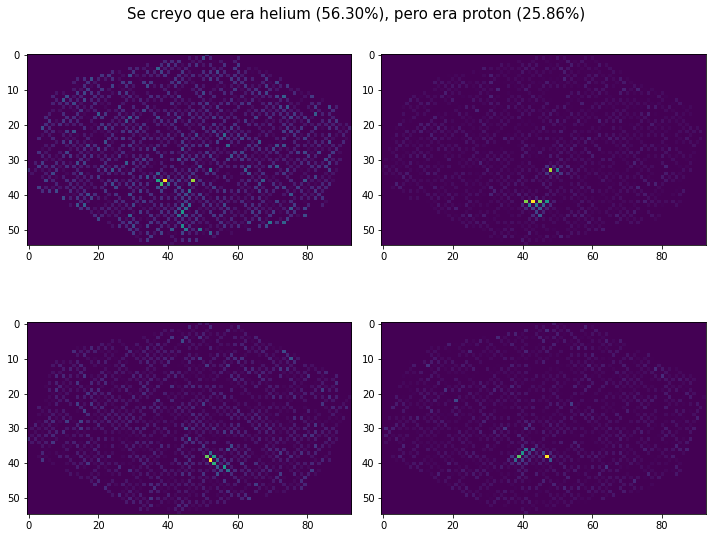

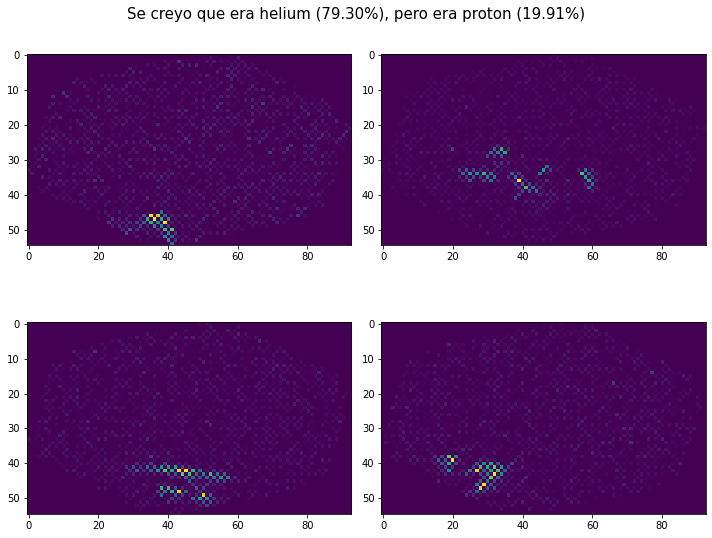

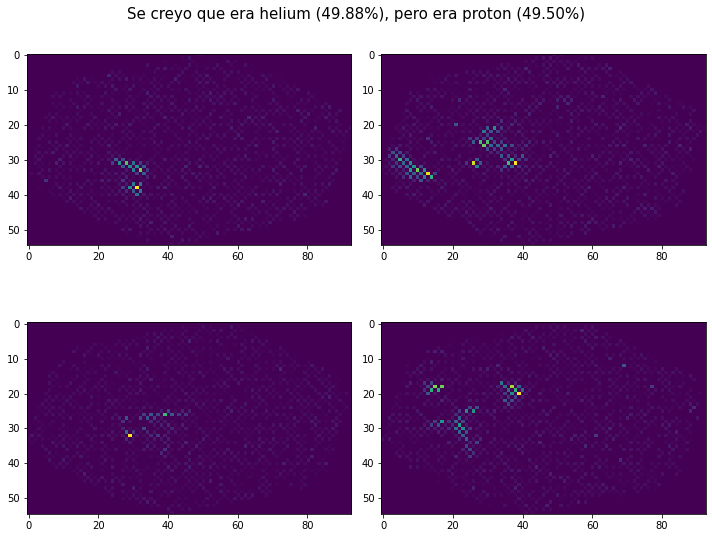

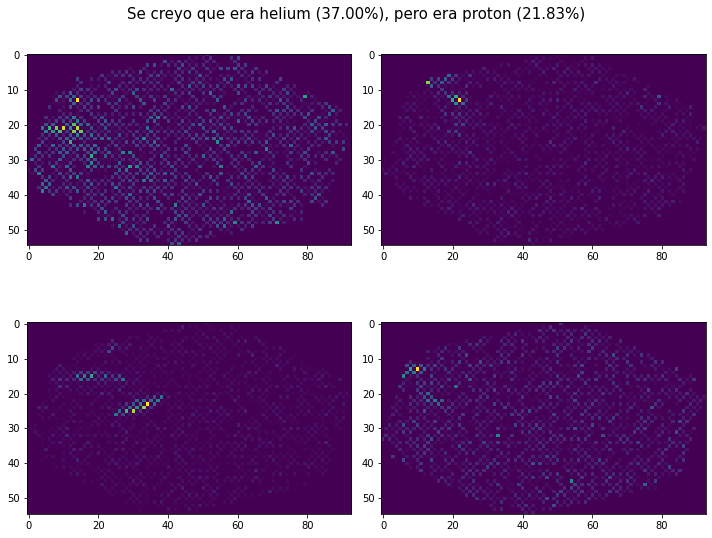

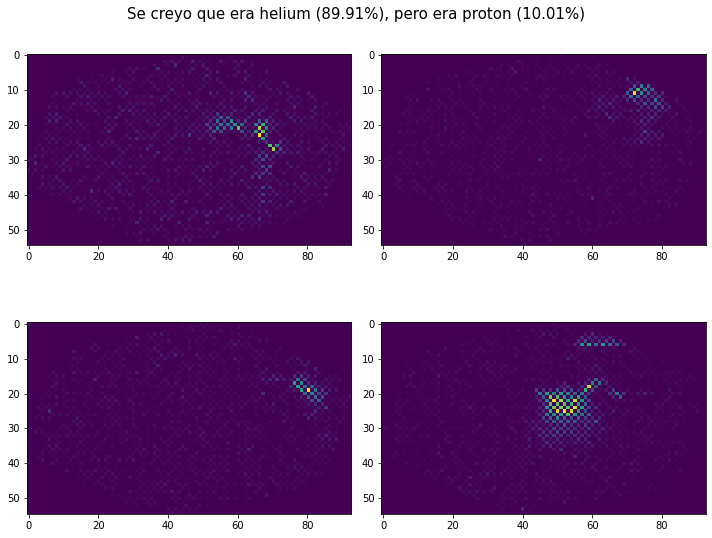

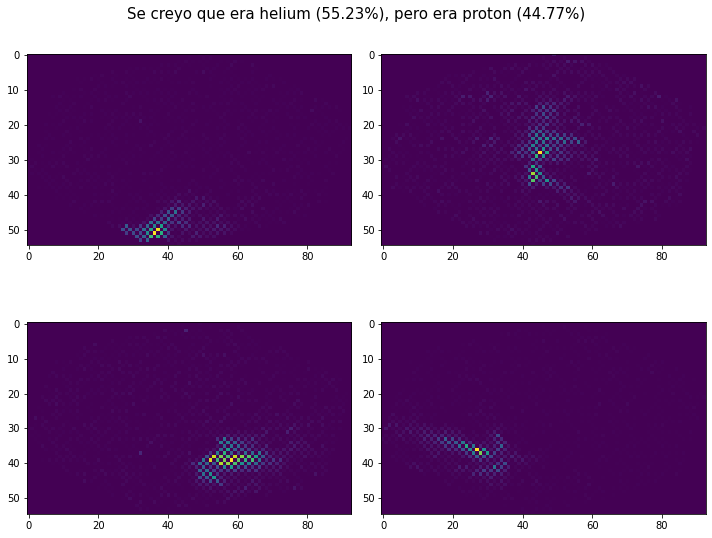

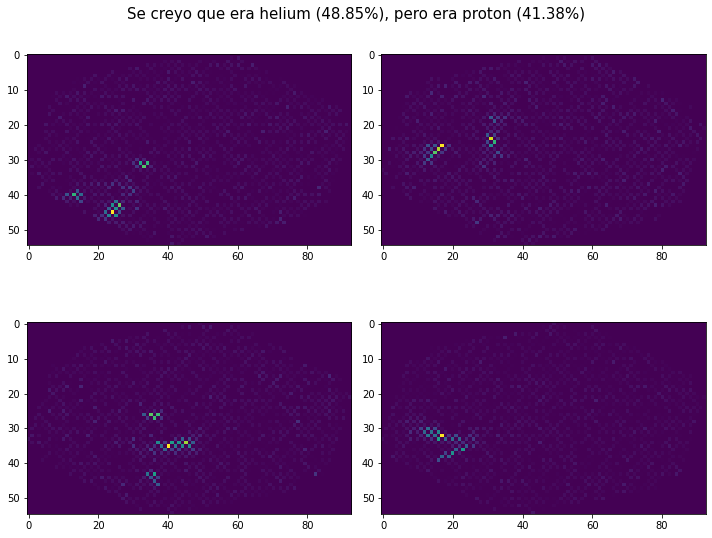

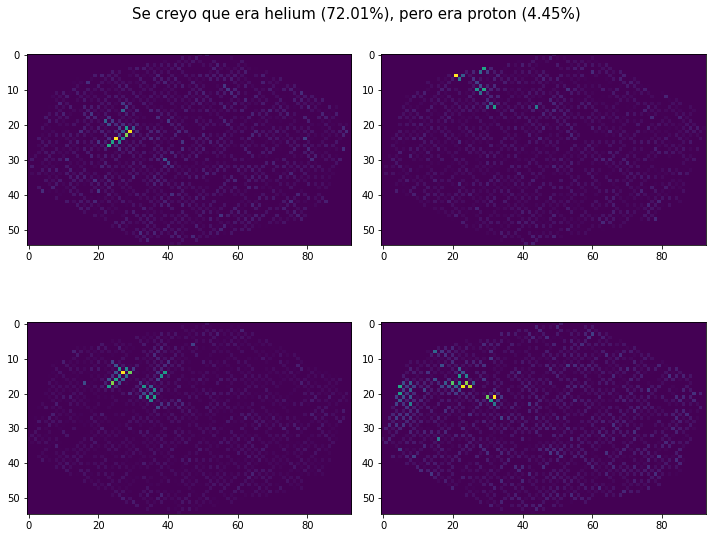

In [ ]:
plot_errors(x_test,y_test,y_predicho,2,3)

# Arreglo funcion carga datos (same_quant BIEN)

Ha ido bien el entrenamiento ultimo, pero comete muchos errores con proton y helio, lo que quiero es que me aprenda un poco mejor a distinguir estas dos, por lo que quiero cargar un dataset un poco mas polarizado hacia estas, de modo que aprenda bien estas.

!!!! Otra opción  es la weighted loss o algp así que es darle mas importancia a los fallos en uno de los outputs (creo que eso existe...)

In [ ]:
# funcion de carga más personalizada

#primero funcion que carga los datos al darle unos telescopios y runs 
def load_data(npy_dir,tels=None,runs=None,indices_runs=None,only_names=False,ending=".npy",test_size=0.2):
    #aplicamos regular expresions para extraer los documentos deseados
    #usamos glob
    #si no pasamos ni los tesls ni las runs, deolvemos todos los arichivos
    #es poco optimo este uso de glob, pero es mas flexivo porque le puedo pasar los tels concretos y los runs concretos
    #si es return sin labels, nos devuelve todo, sin separar siquiera

    lista=[]
    if ((type(tels)==list) or (type(tels)==np.ndarray)):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            for j in runs:
                regex=f"{npy_dir}/*_tel_{i}_run_{str(j).zfill(2)}_?{ending}"
                aux=glob.glob(regex)
                if aux:
                    lista.extend(aux)
                else:
                    #si no lo encuentra entonces nos saldra mal la cosa
                    print("ERROR")
                    print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")
    else:
        for j in runs:
            regex=f"{npy_dir}/*_tel_{tels}_run_{str(j).zfill(2)}_?{ending}"
            aux=glob.glob(regex)
            if aux:
                lista.extend(aux)
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")

    if only_names:
        return lista
    else:
        if indices_runs is not None:
            lista_npy=np.load(lista[0])[indices_runs[0]]
            #si no hay mas no se cargan y ya esta
            for m,k in enumerate(lista[1:]):
                lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
            return lista_npy
        else:
            lista_npy=np.load(lista[0])
            for m,k in enumerate(lista[1:]):
                lista_npy=np.concatenate((lista_npy,np.load(k)),axis=0)
            return lista_npy

#ahora tenemos que saber cuales son los elementos que se comparten entre todos los telescopios


def get_common_events(npy_dir_base,tels=None,run=None):
    #esta funcion nos sirve para obtener los indices de eventos comunes tal que 
    #esto es necesario para que las imagenes sean del mismo evento

    #TENEMOS QUE MIRAR PARA UNA RUN, TODOS LOS TELESCOPIOS QUE NOS INTERESEN,
    #SIN IMPORTAR EL ELEMENTO, SOLO LOS TELESCOPIOS DE LA RUN Y EL EMENTO QUE TOQUE
    lista=[]
    if (type(tels)==list) or (type(tels)==np.ndarray):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            regex=f"{npy_dir_base}/id_eventos_*_tel_{i}_run_{str(run).zfill(2)}.npy"
            aux=glob.glob(regex)
            if aux:
                lista.append(np.load(aux[0]))
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir_base)} no se encuentra el {os.path.basename(regex)}.")
    else:
        print("ERROR")
        return None
    if len(tels)==1:
        eventos_comunes=lista[0]
    else:
        sets=[set(i) for i in lista]
        #devolvemos una lista de los INDICES de los eventos que SON COMUNES y podemos coger
        eventos_comunes=sorted(list(sets[0].intersection(*sets[1:])))
        del sets
    indices_master=[]
    for i,j in enumerate(tels):
        indices=[]
        for k in eventos_comunes:
            indices.append(np.where(lista[i]==k)[0][0])
        indices_master.append(np.array(indices))
    return np.array(indices_master)



#por ultimo la funcion que nos va a administrar toda la carga de datos, aqui es donde pondemos la funcion de elergir el numero de runs para cada elementos


def load_dataset_personalizado(base_dir,pre_name_folders="npy_",telescopios=None,lista_list_runs=None,elementos=None,test_size=0.2,same_quant=False):#,ponderaciones=None):
    #telescopios deb ser una lista , aunque solo haya uno 1
    #esta funcion es una version de load_dataset donde puedes escoger cuantas runs de cada elemento, tambien puedes escoger ninguna
    #tambien (como en la otra, puedes decidir que haya mas o menos las mismas de todas same_quant)
    #list_RUNS Ahora es una lista de listas


    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    eventos_elementos=[]
    numero_eventos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir}/{pre_name_folders}{j}"
        eventos_runs=[]
        list_runs=lista_list_runs[i]
        aux_num_events=0
        for l,k in enumerate(list_runs):
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            print(j,k,list_runs,aux_events.shape)
            eventos_runs.append(aux_events)
            aux_num_events+=aux_events.shape[1]
        numero_eventos.append(aux_num_events)
        eventos_elementos.append(eventos_runs)
    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]
    print("_______________")
    #prueba=ponderaciones
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir}/{pre_name_folders}{j}"
            list_runs=lista_list_runs[i]
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)
            if same_quant:
                media=int(np.median(numero_eventos))
                data_aux=data_aux[:media]
            print(j,k,data_aux.shape)

            if (i==0) :
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.zeros(label_size)
                data=data_aux
                del data_aux
            else:
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.concatenate((labels,np.ones(label_size)*i),axis=0)
                data=np.concatenate((data,data_aux),axis=0)
                del data_aux
        #print(data.shape)
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            labels=tf.keras.utils.to_categorical(labels)
            x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
            del data,labels
            y_train_list=y_train
            y_test_list=y_test
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            #del y_train,y_test
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            del data
        #del x_train,x_test

    if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
        print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
        return None
    else:
        print("EXITO")
        if len(telescopios)==1:
            return x_train_list[0],x_test_list[0],y_train_list,y_test_list
        else:
            return x_train_list,x_test_list,y_train_list,y_test_list



In [ ]:
#una funcion para crear la lista de list runs 
def create_lista_list_runs(num_events,init_events=None,random_select=False,max_runs=None):
    #solo tenemos que indicar la cantidad de runs que queremos de cada uno de los elementos
    #tambien podemos indicar el numero maximo de runs disponibles y si los queremos aleatorios
    if type(init_events)==int:
        if init_events==0:
            init_events=1
        init_events=np.ones(len(num_events))*init_events
    elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    if max_runs is None:
        max_runs=[41,40,40,40,20,40,40]
    lista_master=[]
    for i,j in enumerate(num_events):
        if random_select:
            if j> max_runs[i]:
                print("No hay tantas runs.")
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=max_runs[i])
            else:
                list_aux=np.random.randint(low=1,high=max_runs[i]+1,size=j)
        else: 
            if init_events is not None:
                if (j+init_events[i]+1)> max_runs[i]:
                    print(f"Error, para el {i} te estas pasando de run, no hay runs {np.arange(max_runs[i]+1,init_events[i]+j+2,dtype=int)}")
                    list_aux=np.arange(init_events[i],1+max_runs[i],dtype=int)
                else:
                    list_aux=np.arange(init_events[i],j+init_events[i],dtype=int)


            else:
                if (j+1) > max_runs[i]:
                    print(f"Error, para el \"{i}\" te estas pasando de run, no hay run {np.arange(max_runs[i]+1,j+2,dtype=int)}")
                    list_aux=np.arange(1,max_runs[i]+1,dtype=int)
                else:
                    list_aux=np.arange(1,j+1,dtype=int)
        lista_master.append(list_aux)
    return np.array(lista_master,dtype=object)


In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
a=create_lista_list_runs(num_events=[1,3,3,4,4,4,4],random_select=True)
x_train,x_test,y_train,y_test=load_dataset_personalizado(npy_base,telescopios=[6,11,4,5],lista_list_runs=a,test_size=0.15,same_quant=True)

gamma 41 [41] (4, 1999)
electron 38 [38 32  2] (4, 115)
electron 32 [38 32  2] (4, 123)
electron 2 [38 32  2] (4, 106)
proton 35 [35 18 31] (4, 345)
proton 18 [35 18 31] (4, 347)
proton 31 [35 18 31] (4, 356)
helium 21 [21  5 14 37] (4, 241)
helium 5 [21  5 14 37] (4, 242)
helium 14 [21  5 14 37] (4, 229)
helium 37 [21  5 14 37] (4, 227)
iron 6 [ 6  3  7 12] (4, 136)
iron 3 [ 6  3  7 12] (4, 111)
iron 7 [ 6  3  7 12] (4, 124)
iron 12 [ 6  3  7 12] (4, 130)
nitrogen 9 [ 9  1 34 20] (4, 122)
nitrogen 1 [ 9  1 34 20] (4, 106)
nitrogen 34 [ 9  1 34 20] (4, 118)
nitrogen 20 [ 9  1 34 20] (4, 101)
silicon 16 [16 33 38  2] (4, 144)
silicon 33 [16 33 38  2] (4, 146)
silicon 38 [16 33 38  2] (4, 130)
silicon 2 [16 33 38  2] (4, 135)
_______________
gamma 6 (555, 55, 93)
electron 6 (344, 55, 93)
proton 6 (555, 55, 93)
helium 6 (555, 55, 93)
iron 6 (501, 55, 93)
nitrogen 6 (447, 55, 93)
silicon 6 (555, 55, 93)
gamma 11 (555, 55, 93)
electron 11 (344, 55, 93)
proton 11 (555, 55, 93)
helium 11 (555

# Entrenar modelo con mas protones y helium para que aprenda



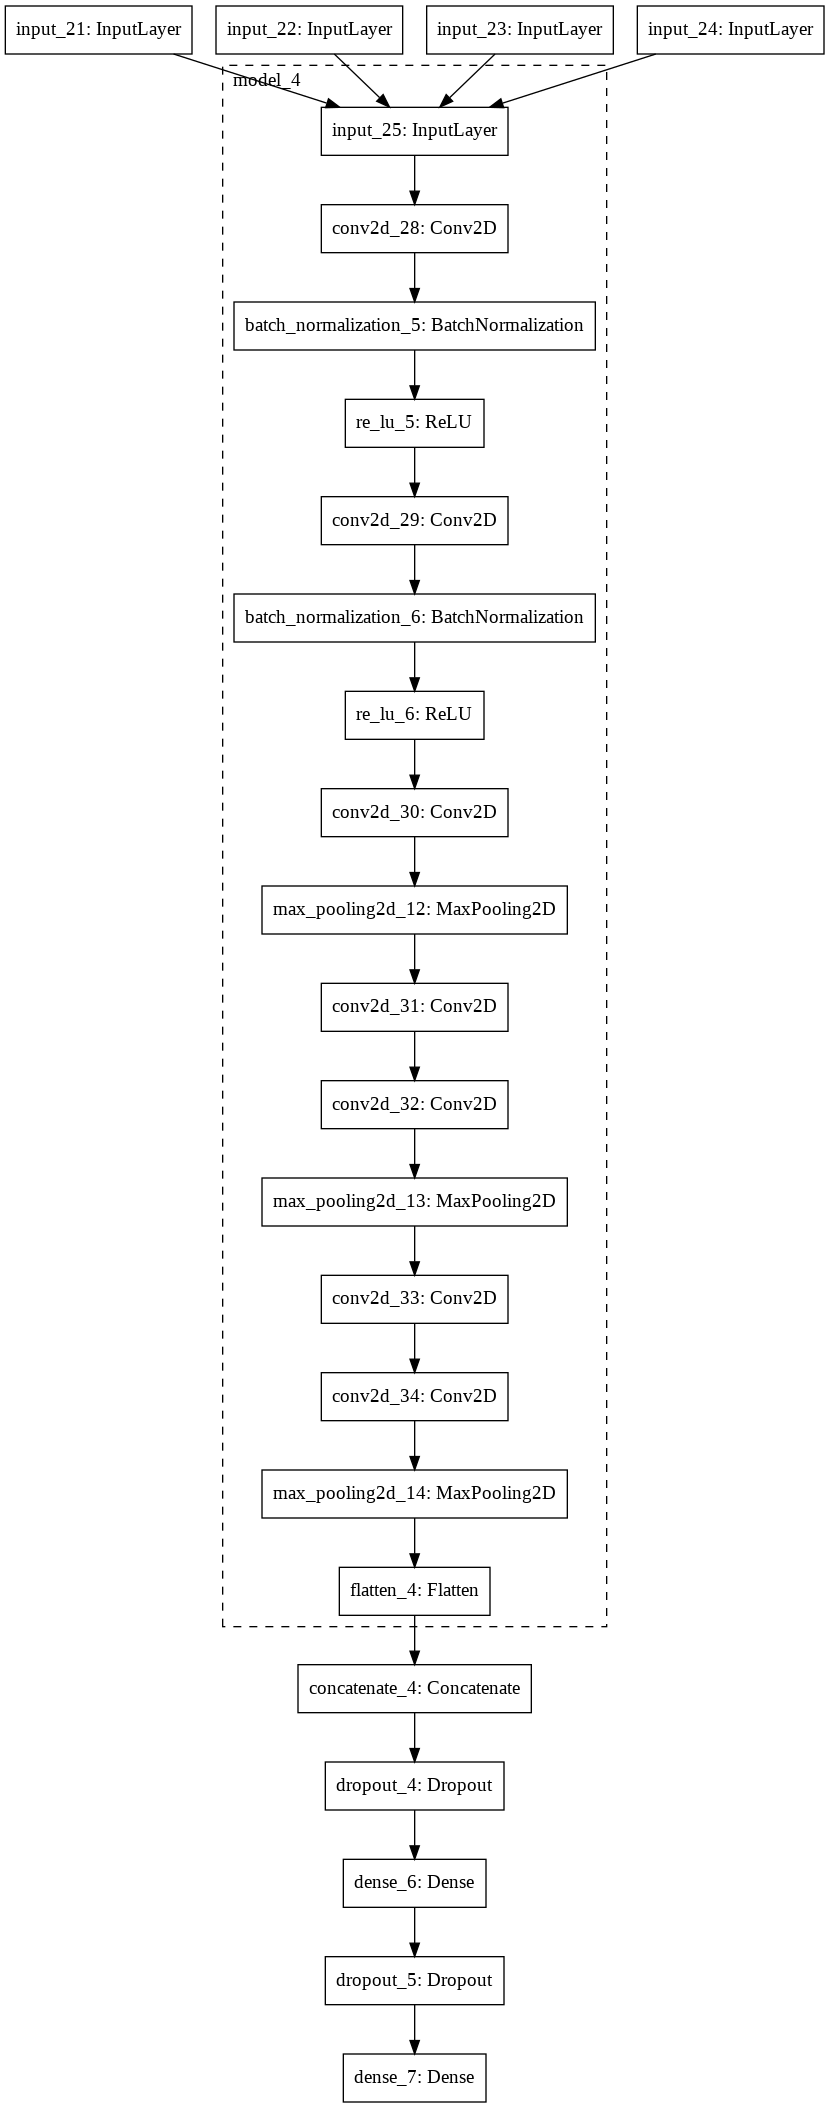

In [ ]:
#cargamos el modelo del otro dia
model=tf.keras.models.load_model("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/modelo_bien_tels_4_5_6_11_precision_082.h5")
tf.keras.utils.plot_model(model,expand_nested=True)

In [ ]:
model.evaluate(x_train,y_train)

94/94 [==============================] - 4s 41ms/step - loss: 1.9897 - accuracy: 0.5477


[1.9897148609161377, 0.5477386713027954]

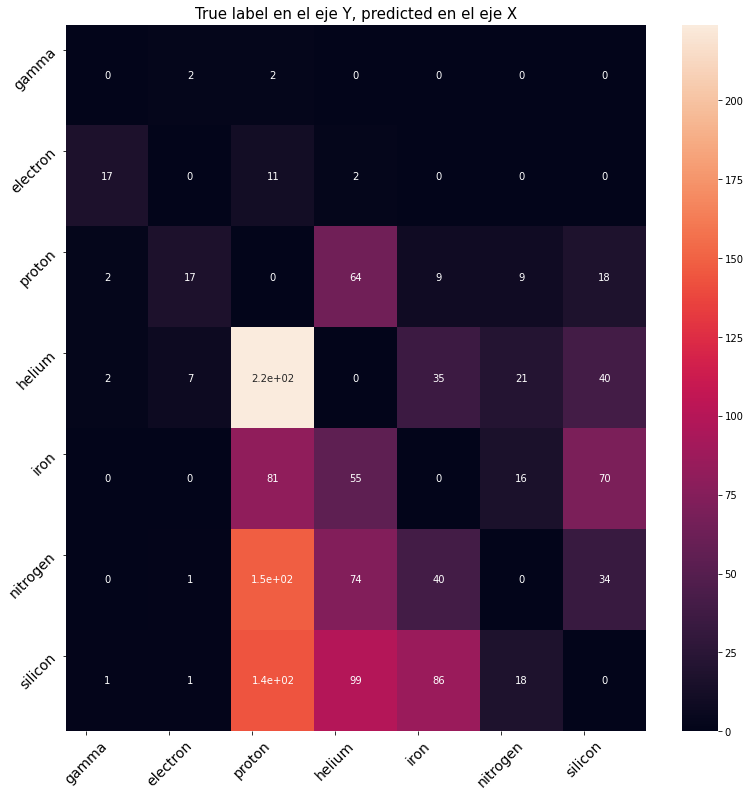

In [ ]:
comp_and_diplay_conf_matrix(y_train,model.predict(x_train))

se equivoca mucho y se piensa que todo son protones, vamos a meterle muchos silicon, nitrgen, iron, helium para que aprenda a diferenciarlo bien.

Model: "prueba_red"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_62 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_63 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_64 (InputLayer)           [(None, 55, 93, 1)]  0                                            
_________________________________________________________________________________________

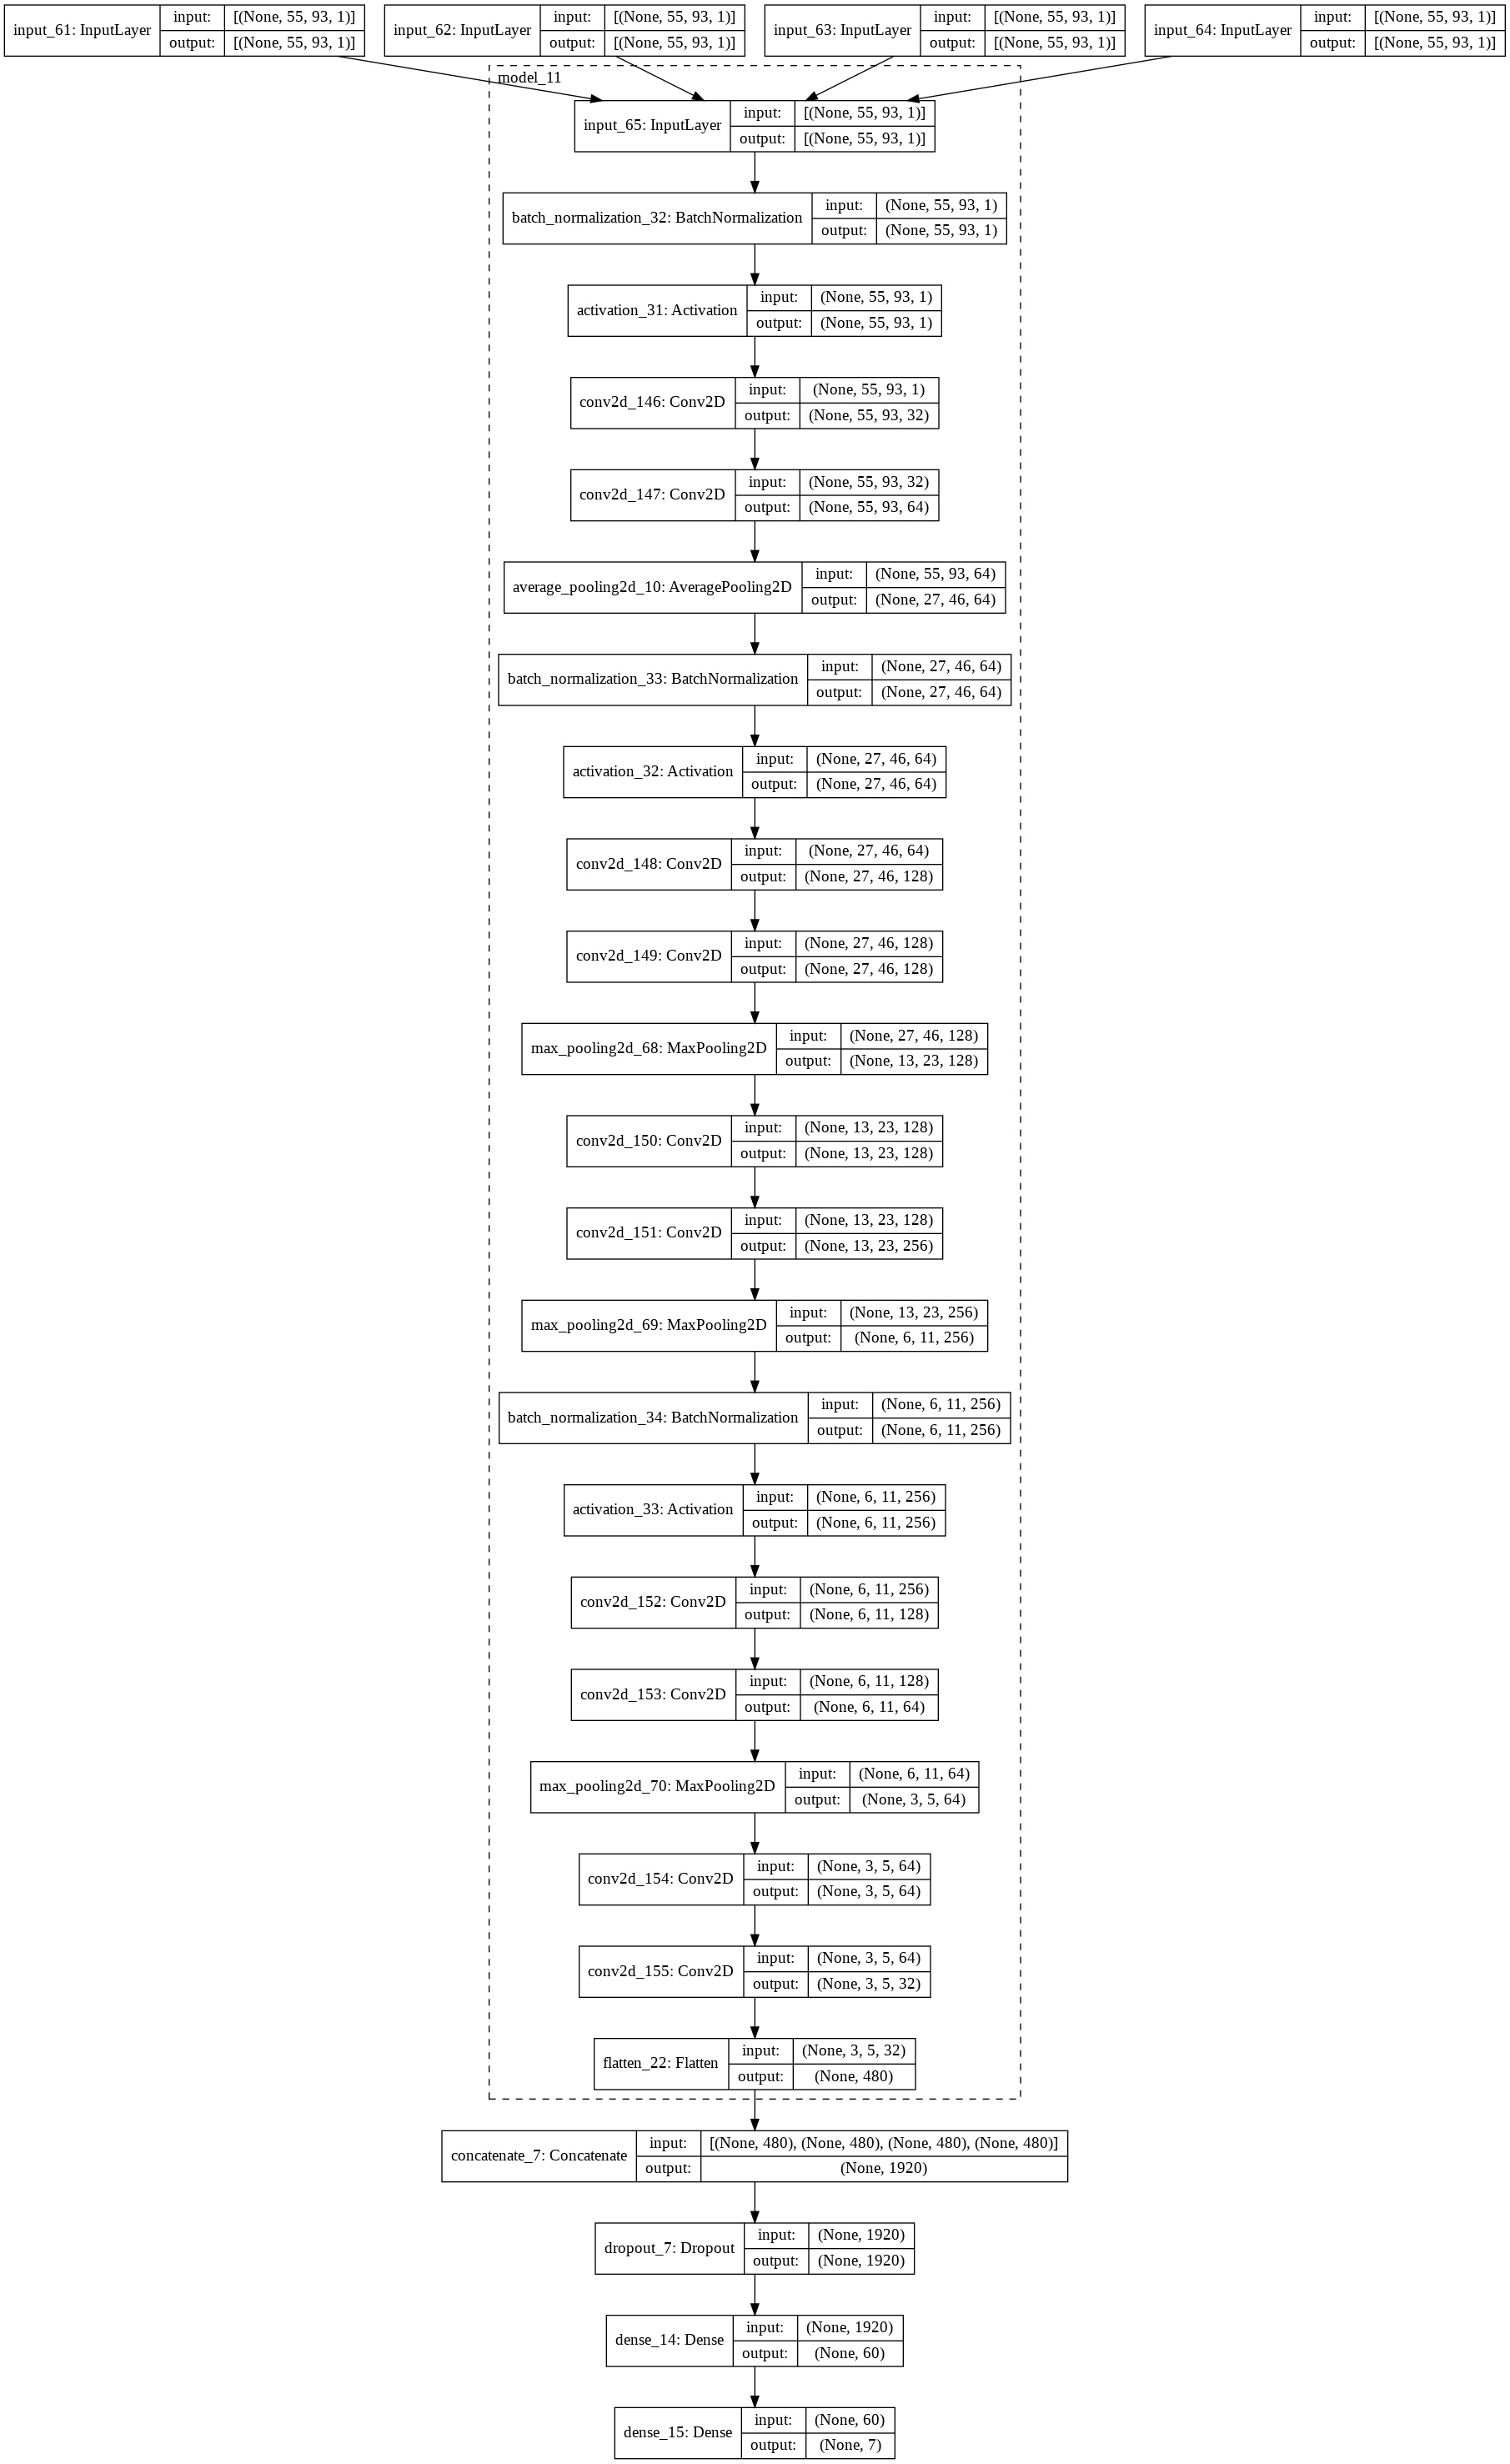

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
#creamos el model de zero
#tenemos 4 inputs
telesc=4
input1=tf.keras.Input(shape=(55,93,1))
input2=tf.keras.Input(shape=(55,93,1))
input3=tf.keras.Input(shape=(55,93,1))
input4=tf.keras.Input(shape=(55,93,1))

#autoencoder=tf.keras.models.load_model(f"{npy_base}/autoencoder_bien.h5")
#autoencoder.trainable=False
#entran los 4 inputs y nos dan 4 outputs diferentes

#output1=autoencoder(input1)
#output2=autoencoder(input2)
#output3=autoencoder(input3)
#output4=autoencoder(input4)

#ahora los outputs los procesamos tal que todos se procesan por el mismo submodelo
aux_input=tf.keras.Input(shape=(55,93,1))
x=tf.keras.layers.BatchNormalization()(aux_input)
x=tf.keras.layers.Activation("relu")(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same")(x)
x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
#x=tf.keras.layers.Activation("relu")(x)
x=tf.keras.layers.AveragePooling2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation("relu")(x)
x=tf.keras.layers.Conv2D(128,(3,3),padding="same")(x)
x=tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),padding="same")(x)
x=tf.keras.layers.Conv2D(256,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Activation("relu")(x)
x=tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
#x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Flatten()(x)
submodel_conv=tf.keras.Model(inputs=aux_input,outputs=x)


modelito = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64, 7, activation="relu", padding="same",input_shape=[55, 93, 1]),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten()])
#modelito.summary()


final_output1=submodel_conv(input1)
final_output2=submodel_conv(input2)
final_output3=submodel_conv(input3)
final_output4=submodel_conv(input4)

end_layer=tf.keras.layers.concatenate([final_output1,final_output2,final_output3,final_output4])
end_layer=tf.keras.layers.Dropout(0.5)(end_layer)
end_layer=tf.keras.layers.Dense(60)(end_layer)
end_layer=tf.keras.layers.Dense(7,activation="softmax")(end_layer)
model=tf.keras.Model(inputs=[input1,input2,input3,input4],outputs=end_layer,name="prueba_red")
model.summary()
tf.keras.utils.plot_model(model,expand_nested=True,show_shapes=True)

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
#hacemos un bucle que nos entrene atraves de muchas iteraciones
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=14)
hist_master=[]
bat=64
for i in range(9):
    if i ==5:
        bat=128
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
    init_aux=np.ones(7)*(1+i*4)
    init_aux[4]=i+1
    a=create_lista_list_runs(num_events=[1,9,8,10,9,10,10],init_events=init_aux,random_select=False)
    x_train,x_test,y_train,y_test=load_dataset_personalizado(npy_base,telescopios=[6,11,4,5],lista_list_runs=a,test_size=0.17,same_quant=True)
    hist=model.fit(x_train,y_train,epochs=55,batch_size=bat,validation_data=(x_test,y_test),callbacks=[stop])#,class_weight={0:1,1:1,2:4,3:4,4:2,5:3,6:3})
    hist_master.append(hist)

gamma 1 [1] (4, 1999)
electron 1 [1 2 3 4 5 6 7 8 9] (4, 115)
electron 2 [1 2 3 4 5 6 7 8 9] (4, 106)
electron 3 [1 2 3 4 5 6 7 8 9] (4, 104)
electron 4 [1 2 3 4 5 6 7 8 9] (4, 128)
electron 5 [1 2 3 4 5 6 7 8 9] (4, 128)
electron 6 [1 2 3 4 5 6 7 8 9] (4, 122)
electron 7 [1 2 3 4 5 6 7 8 9] (4, 111)
electron 8 [1 2 3 4 5 6 7 8 9] (4, 95)
electron 9 [1 2 3 4 5 6 7 8 9] (4, 114)
proton 1 [1 2 3 4 5 6 7 8] (4, 327)
proton 2 [1 2 3 4 5 6 7 8] (4, 347)
proton 3 [1 2 3 4 5 6 7 8] (4, 342)
proton 4 [1 2 3 4 5 6 7 8] (4, 346)
proton 5 [1 2 3 4 5 6 7 8] (4, 371)
proton 6 [1 2 3 4 5 6 7 8] (4, 343)
proton 7 [1 2 3 4 5 6 7 8] (4, 367)
proton 8 [1 2 3 4 5 6 7 8] (4, 331)
helium 1 [ 1  2  3  4  5  6  7  8  9 10] (4, 225)
helium 2 [ 1  2  3  4  5  6  7  8  9 10] (4, 249)
helium 3 [ 1  2  3  4  5  6  7  8  9 10] (4, 250)
helium 4 [ 1  2  3  4  5  6  7  8  9 10] (4, 267)
helium 5 [ 1  2  3  4  5  6  7  8  9 10] (4, 242)
helium 6 [ 1  2  3  4  5  6  7  8  9 10] (4, 237)
helium 7 [ 1  2  3  4  5  6  7 

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
submodel_conv.save(f"{npy_base}/BORRAR.h5")

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
a=create_lista_list_runs(num_events=[1,3,2,5,3,5,5],random_select=True)
x_train,x_test,y_train,y_test=load_dataset_personalizado(npy_base,telescopios=[6,11,4,5],lista_list_runs=a,test_size=0.01,same_quant=True)

gamma 41 [41] (4, 1999)
electron 21 [21 40  5] (4, 83)
electron 40 [21 40  5] (4, 126)
electron 5 [21 40  5] (4, 128)
proton 25 [25 31] (4, 338)
proton 31 [25 31] (4, 356)
helium 18 [18 40 13 28 23] (4, 229)
helium 40 [18 40 13 28 23] (4, 261)
helium 13 [18 40 13 28 23] (4, 241)
helium 28 [18 40 13 28 23] (4, 232)
helium 23 [18 40 13 28 23] (4, 245)
iron 18 [18 15  6] (4, 81)
iron 15 [18 15  6] (4, 116)
iron 6 [18 15  6] (4, 136)
nitrogen 6 [ 6 17 35 36 16] (4, 101)
nitrogen 17 [ 6 17 35 36 16] (4, 114)
nitrogen 35 [ 6 17 35 36 16] (4, 137)
nitrogen 36 [ 6 17 35 36 16] (4, 112)
nitrogen 16 [ 6 17 35 36 16] (4, 107)
silicon 37 [37 28  4  3 26] (4, 139)
silicon 28 [37 28  4  3 26] (4, 131)
silicon 4 [37 28  4  3 26] (4, 129)
silicon 3 [37 28  4  3 26] (4, 128)
silicon 26 [37 28  4  3 26] (4, 131)
_______________
gamma 6 (658, 55, 93)
electron 6 (337, 55, 93)
proton 6 (658, 55, 93)
helium 6 (658, 55, 93)
iron 6 (333, 55, 93)
nitrogen 6 (571, 55, 93)
silicon 6 (658, 55, 93)
gamma 11 (658, 

120/120 [==============================] - 3s 22ms/step - loss: 1.1292 - accuracy: 0.5743


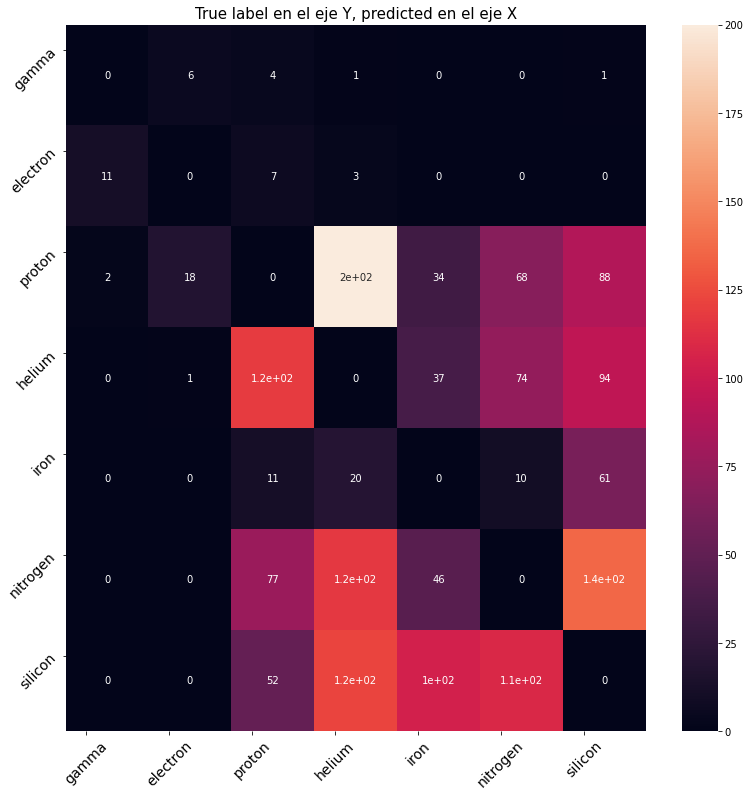

In [ ]:
model.evaluate(x_train,y_train)
comp_and_diplay_conf_matrix(y_train,model.predict(x_train))